# Setting Up The MNIST Dataset

**Import packages and setup environment**

In [40]:
!pip install snntorch
import snntorch as snn
import torch

# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

**Download dataset**

In [41]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

Create a subset of the MNIST data to test on

In [42]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)

print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


**Create dataloaders**

In [43]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Spike Encoding

**Rate coding of MNIST**

Rate coding converts the values of each neuron into a probability. The probability is then used to determine whether the neuron outputs a spike or not. This is repeated for as many timesteps as needed, so that neurons with a probability closer to 1 will fire at a higher rate

In [44]:
# Temporal Dynamics
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)

print(f"Converted vector: {rate_coded_vector}")
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
The output is spiking 42.00% of the time.


[num_steps x batch_size x input dimensions]

In [45]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


**Visualizations**

In [46]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


In [47]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

display(HTML(anim.to_html5_video()))
plt.close(fig)

print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 9


With a lower gain, we reduce the spike frequency. A gain of 0.25 is equivalent to dividing each neuron's value by 4, so they fire less frequently

In [48]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)

display(HTML(anim.to_html5_video()))
plt.close(fig)

As evident from the following figure, a smaller gain results in the image having "grayer" pixels, which in turn represent a smaller value. This smaller value is what causes the lower probability of firing

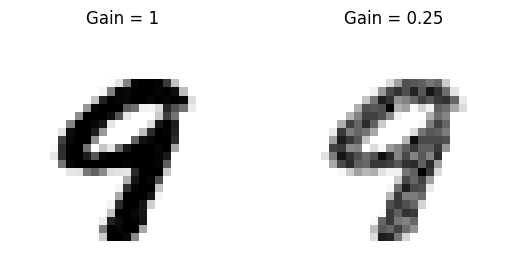

In [49]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

Raster plot of the image

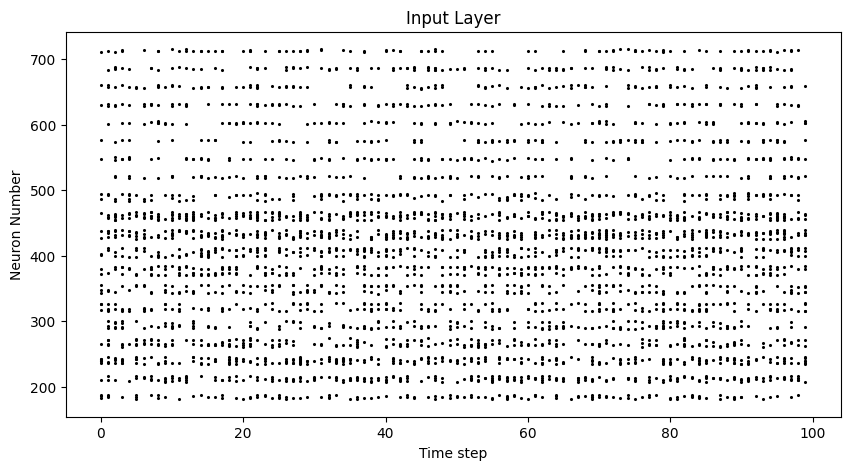

In [50]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

Raster plot for a singular neuron

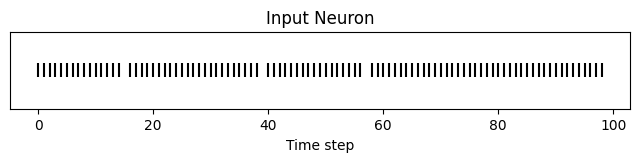

In [51]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

**Latency coding**

Latency coding works by converting the value of a neuron into the time at which the spike fires. The higher the value, the earlier the spike fires. This is on a logarithmic scale, which can be linearized if need be and the spikes can be slowed down based on a variable tau. Linearizing the spikes evenly distributes them

In [52]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

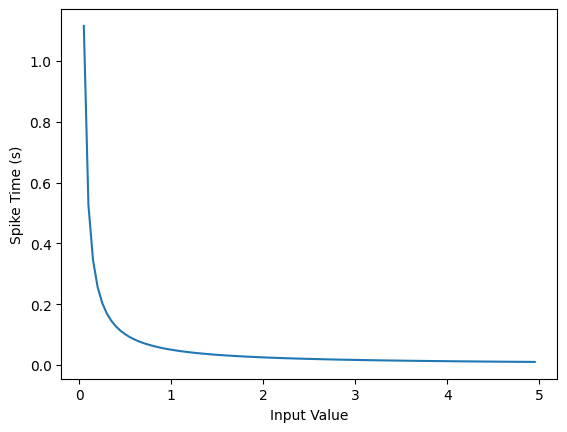

In [53]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

Raster plot of a neuron

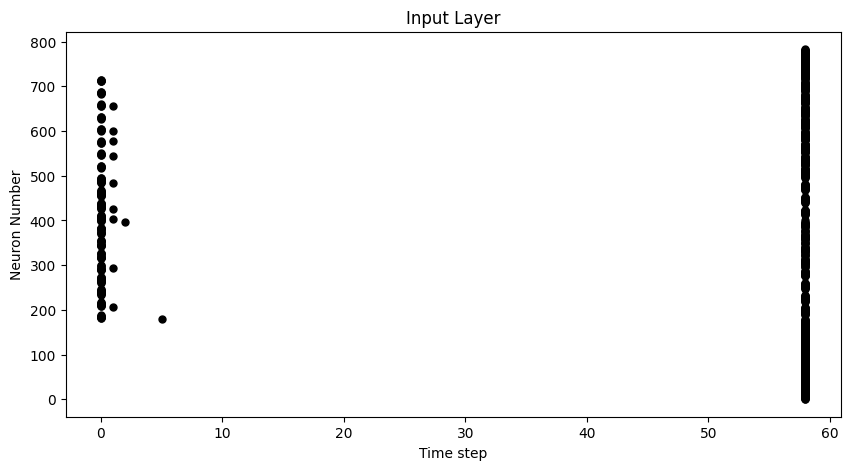

In [54]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

Same raster plot of the latency coding, but linearized

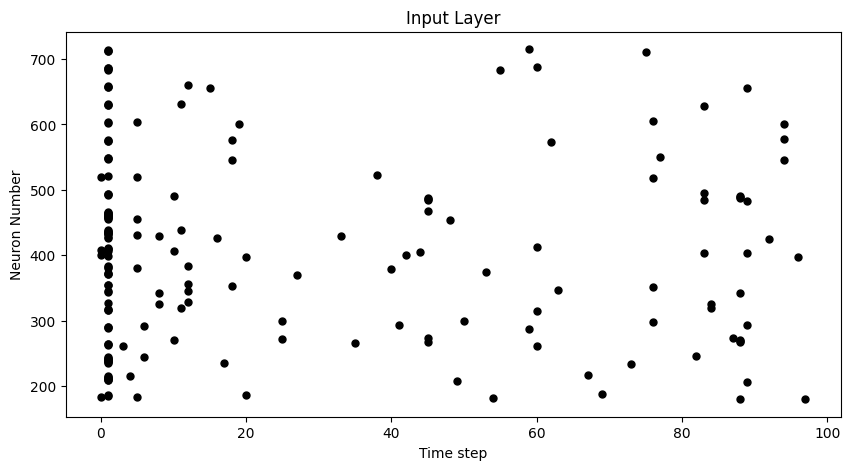

In [58]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [63]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

display(HTML(anim.to_html5_video()))
plt.close(fig)

print(targets_it[0])

torch.Size([100, 28, 28])


tensor(9)


Delta modulation works by only generating a spike if the inputs reach a certain threshold. This can be calculated by claculating the difference between values at a timestep t and values at t-1. A positive and negative spike are on and off spikes respectively

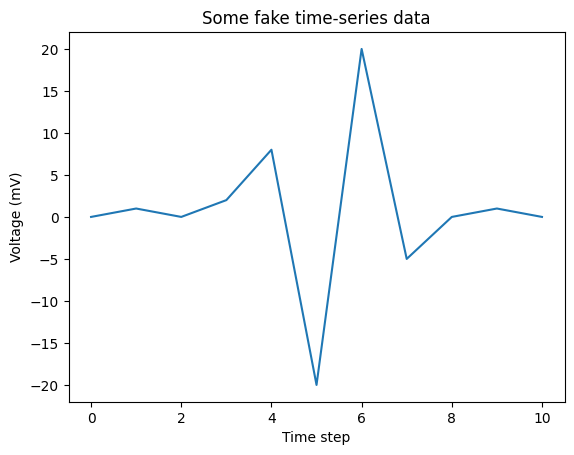

In [64]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

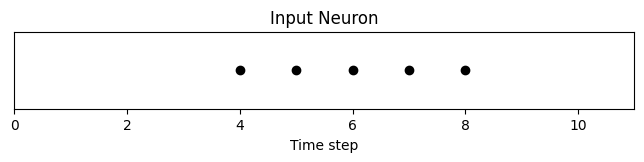

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


In [65]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

print(spike_data)